Setup & Imports

In [1]:
!pip install diffusers transformers accelerate torch torchvision ftfy scipy pillow open_clip_torch
import torch
from diffusers import StableDiffusionPipeline
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import open_clip

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 89.9 MB/s eta 0:00:00


Flax classes are deprecated and will be removed in Diffusers v1.0.0. We recommend migrating to PyTorch classes or pinning your version of Diffusers.
Flax classes are deprecated and will be removed in Diffusers v1.0.0. We recommend migrating to PyTorch classes or pinning your version of Diffusers.


Model Loading

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

pipe = StableDiffusionPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    torch_dtype=torch.float16
).to(device)

pipe.enable_attention_slicing()

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

text_encoder/model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

safety_checker/model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

unet/diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

vae/diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`torch_dtype` is deprecated! Use `dtype` instead!


Prompt Sets (Controlled Variations)

In [3]:
base_prompt = "A modern poster design for a coffee shop"

prompt_variants = {
    "base": base_prompt,
    "explicit_layout": base_prompt + ", centered layout, clean typography",
    "style_tokens": base_prompt + ", minimalist, flat design, vector art",
    "structured": "Poster design. Title text at top. Image in center. Minimalist style.",
    "overloaded": base_prompt + ", ultra-detailed, cinematic lighting, 8k, photorealistic"
}

Image Generation Loop

In [4]:
def generate(prompt, seed):
    generator = torch.Generator(device=device).manual_seed(seed)
    return pipe(prompt, generator=generator, num_inference_steps=30).images[0]

results = {}

for name, prompt in prompt_variants.items():
    images = [generate(prompt, seed=i) for i in range(3)]
    results[name] = images

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Quantitative Evaluation

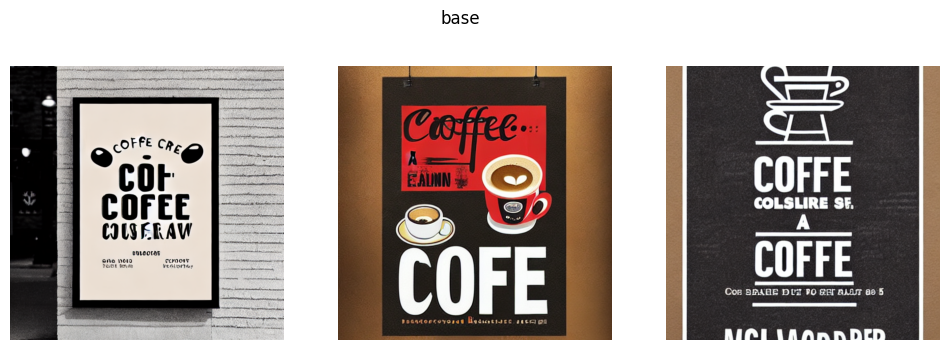

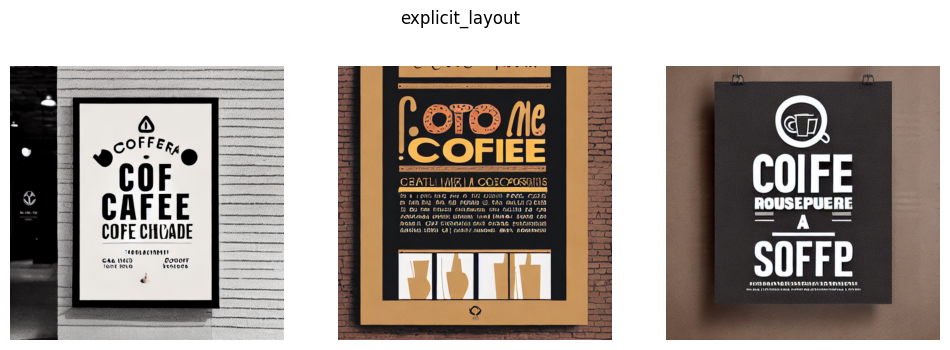

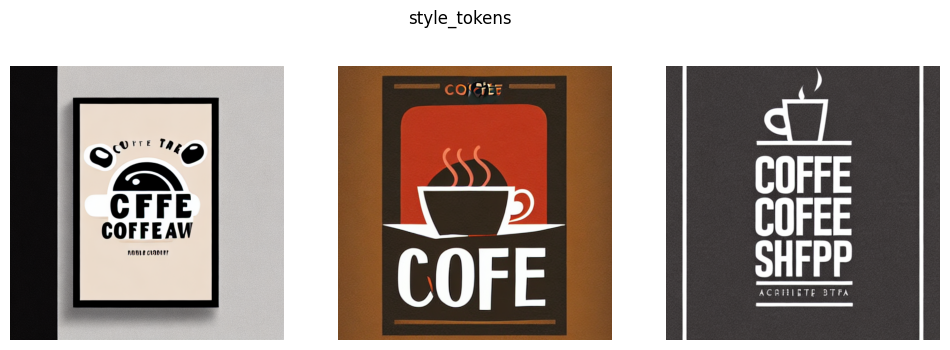

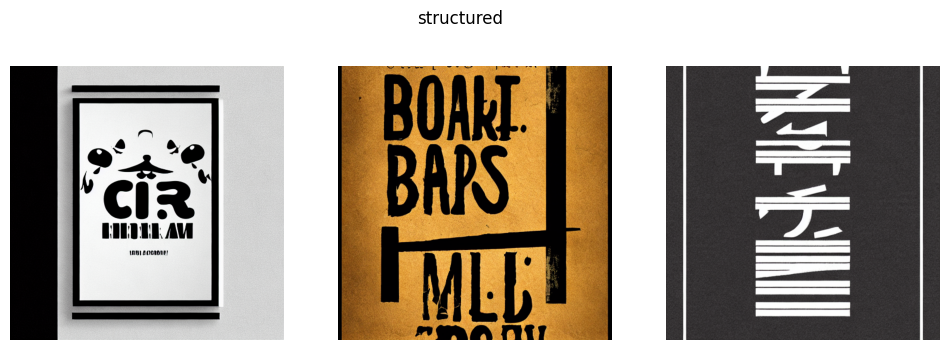

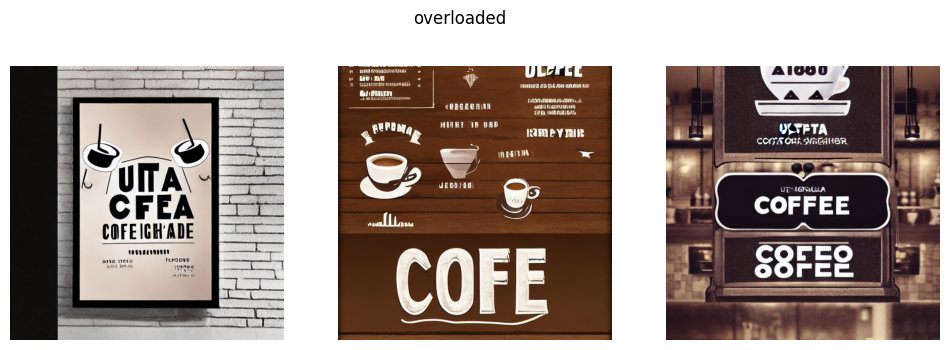

In [5]:
def show_grid(images, title):
    fig, axes = plt.subplots(1, len(images), figsize=(12,4))
    for ax, img in zip(axes, images):
        ax.imshow(img)
        ax.axis("off")
    fig.suptitle(title)
    plt.show()

for k, imgs in results.items():
    show_grid(imgs, k)

Quantitative Analysis

In [7]:
model, _, preprocess = open_clip.create_model_and_transforms(
    'ViT-B-32', pretrained='openai'
)
tokenizer = open_clip.get_tokenizer('ViT-B-32')

model = model.to(device)

def clip_score(image, text):
    image = preprocess(image).unsqueeze(0).to(device)
    text = tokenizer([text]).to(device)
    with torch.no_grad():
        image_feat = model.encode_image(image)
        text_feat = model.encode_text(text)
    return torch.cosine_similarity(image_feat, text_feat).item()

scores = {}

for k, imgs in results.items():
    scores[k] = np.mean([clip_score(img, base_prompt) for img in imgs])

scores

{'base': np.float64(0.3277217745780945),
 'explicit_layout': np.float64(0.3386930227279663),
 'style_tokens': np.float64(0.3206440508365631),
 'structured': np.float64(0.24947709838549295),
 'overloaded': np.float64(0.3230620821317037)}

Findings & Next Steps

### Findings

- Explicit layout prompts achieved the highest CLIP similarity, indicating improved semantic alignment when spatial and typographic cues are included.

- Base and overloaded prompts showed comparable CLIP scores, suggesting that generic quality tokens increase visual complexity without meaningfully improving alignment.

- Structured prompts produced the lowest CLIP similarity despite improved layout consistency, highlighting a tradeoff between rigid structural guidance and semantic fidelity.

- Style-focused prompts preserved semantic alignment while increasing aesthetic consistency, but did not outperform explicit layout conditioning.

- Overall, prompt structure meaningfully affects both alignment and composition, acting as a soft prior that trades off flexibility for control.

### Limitations
- Experiments were limited to a single pretrained model (Stable Diffusion v1.5).
- CLIP similarity does not directly capture layout or typography quality.
- No fine-tuning, ControlNet, or multimodal conditioning was explored.

### Next Steps
- Incorporate ControlNet or other spatial conditioning methods to decouple layout control from semantic alignment.

- Compare Stable Diffusion v1.5 with SDXL to assess improvements in layout and typography fidelity.

- Evaluate typography and layout quality using task-specific or human-in-the-loop metrics beyond CLIP.

- Analyze variance across seeds to quantify diversity–consistency tradeoffs more rigorously.

- Extend experiments to multimodal conditioning (e.g., layout sketches or bounding boxes) to better support design workflows.